In [1]:
import requests
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

# Data sources of 2019 nCoV
Acknowledgement: 
- API from https://lab.isaaclin.cn/nCoV/
- https://github.com/jianxu305/nCov2019_analysis/blob/master/src/demo.ipynb

## 实时获取需要的数据

In [2]:
def parse_time(data):
    df = pd.DataFrame(data)
    try:
        if np.any(['Time' in name for name in df.columns]):
            for time_name in df.columns[['Time' in name for name in df.columns]]:
                df[time_name] = pd.to_datetime(df.loc[:, time_name], unit='ms')
    except Exception as e:
        print(e)
    # add new column of the updating "Date" instead of concrete time
    if 'updateTime' in df.columns:
        df['updateDate'] = pd.Series([pd.to_datetime(item).date() for item in df['updateTime']])
    elif 'pubDate' in df.columns:
        df['pubTime'] = pd.to_datetime(df.loc[:, 'pubDate'], unit='ms')
        df['pubDate'] = pd.Series([pd.to_datetime(item).date() for item in df['pubTime']])
        
    return df

def query_counts_data(category='area', archival=False, province='all'):
    '''
    API for retrieving data from https://lab.isaaclin.cn/nCoV/.
    
    Parameters:
        Category (str): available options are 'overall', 'area'.
            Check the above website for more.
        archival (bool): whether retrieve archival time-series data. 
            Default is False, only retrieve today's data.
        province (str): name of specific province. Use 'all' to get data from all provinces and countries.
            Notice: full name is required ("湖北省", instead of "湖北"). 
    Returns:
        df (pandas.DataFrame): dataframe object. 
    
    '''
    import requests
    import pandas as pd
    assert isinstance(category, str), 'Input "catecory" must be a string!'
    
    url = 'https://lab.isaaclin.cn/nCoV/api/' + category
    url += '?latest={}'.format(int(not archival))
    if province is not 'all':
        url += '&province=' + province

    req = requests.get(url)
    if req.status_code != 200 or req.json()['success'] is False:
        raise ValueError('The connection fails! Please check input arguments.')
        return False
    else:
        results = req.json()['results']
        df = parse_time(results)
        return df
    
def aggregate_Daily(df):
    frm_list = []
    for key, frm in df.sort_values(['updateDate']).groupby(['provinceName', 'updateDate']):
        frm_list.append(frm.sort_values(['updateTime'])[-1:])
    return pd.concat(frm_list).sort_values(['updateTime', 'provinceName']).loc[::-1]

def parse_city(city_row):
    return pd.DataFrame(city_row.values[0])


In [3]:
area = query_counts_data(category='area', archival=True, province='湖北省') # not very slow
area[:3]

,provinceName,provinceShortName,confirmedCount,suspectedCount,curedCount,deadCount,comment,locationId,cities,country,updateTime,createTime,modifyTime,operator,updateDate
0,湖北省,湖北,24953,0.0,1204,699,,420000.0,"[{'cityName': '武汉', 'confirmedCount': 13603, '...",中国,2020-02-08 09:10:41.955,NaT,NaT,NaN,2020-02-08
1,湖北省,湖北,24953,0.0,1133,699,,420000.0,"[{'cityName': '武汉', 'confirmedCount': 13603, '...",中国,2020-02-08 08:19:57.683,NaT,NaT,NaN,2020-02-08
2,湖北省,湖北,24953,0.0,1132,699,,420000.0,"[{'cityName': '武汉', 'confirmedCount': 13603, '...",中国,2020-02-08 07:49:31.333,NaT,NaT,NaN,2020-02-08


In [4]:
df = aggregate_Daily(area)[::-1]

In [5]:
mask = df['updateDate'] == datetime.date(year=2020, month=2, day=5)
city = parse_city(df[mask]['cities'])
city

,cityName,confirmedCount,suspectedCount,curedCount,deadCount,locationId
0,武汉,10117,0,432,414,420100
1,孝感,1886,0,9,25,420900
2,黄冈,1807,0,62,29,421100
3,随州,834,0,9,9,421300
4,荆州,801,0,18,10,421000
5,襄阳,787,0,10,2,420600
6,黄石,566,0,25,2,420200
7,宜昌,563,0,9,6,420500
8,荆门,508,0,21,17,420800
9,鄂州,423,0,8,18,420700


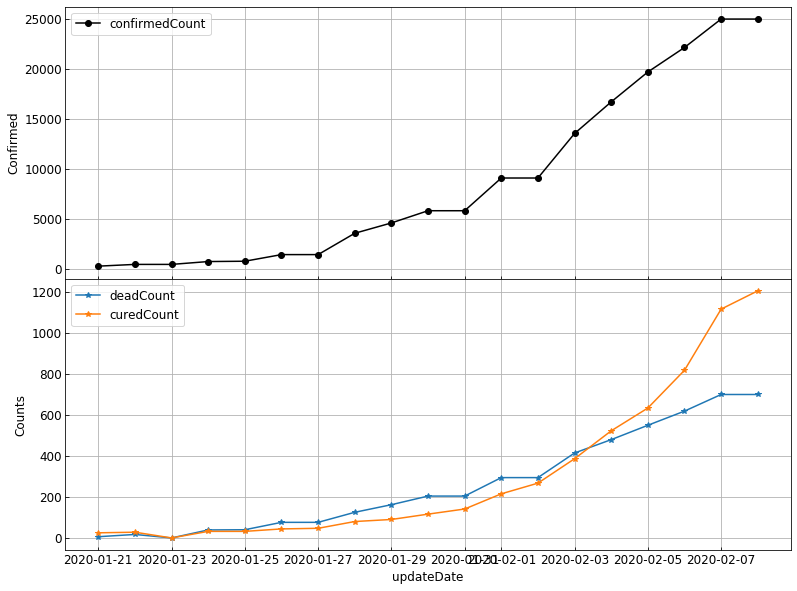

In [6]:
plt.rcParams['font.size'] = 12.0

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(13, 10))
df.plot(y=['confirmedCount'], x='updateDate', style='-*', ax=ax1, grid=True, logy=False, color='black', marker='o')
ax1.set_ylabel("Confirmed")

df.plot(y=['deadCount', 'curedCount'], x='updateDate', style='-*', grid=True, ax=ax2, sharex=True)
ax2.set_ylabel("Counts")

plt.subplots_adjust(hspace=0.0)
ax1.tick_params(direction='in')
ax2.tick_params(direction='in')

## 利用已有的数据

In [7]:
df = pd.read_csv('https://github.com/BlankerL/DXY-2019-nCoV-Data/raw/master/csv/DXYArea.csv')
df = parse_time(df)

non convertible value 2020-02-08 16:35:10.822 with the unit 'ms'


In [8]:
def aggregate_daily_csv(df):
    frm_list = []
    for key, frm in df.sort_values(['updateDate']).groupby(['provinceName', 'cityName', 'updateDate']):
        frm_list.append(frm.sort_values(['updateTime'])[-1:])
    return pd.concat(frm_list).sort_values(['updateTime', 'provinceName', 'cityName']).loc[::-1]

In [9]:
jingmen = df[df['cityName'] == '荆门']
jingmen_daily = aggregate_daily_csv(jingmen)

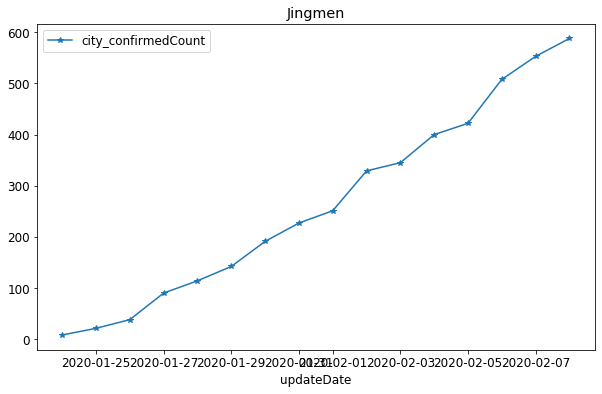

In [10]:
jingmen_daily.plot(y='city_confirmedCount', x='updateDate', style='-*', figsize=(10, 6), title='Jingmen')

## 新闻报道？？

In [11]:
def query_news_data(category='news', num='all', province='all'):
    '''
    API for retrieving news data from https://lab.isaaclin.cn/nCoV/.
    
    Parameters:
        Category (str): available options are 'news'.
            Check the above website for more.
        archival (bool): whether retrieve archival time-series data. 
            Default is False, only retrieve today's data.
        province (str): name of specific province. Use 'all' to get data from all provinces and countries.
            Notice: full name is required ("湖北省", instead of "湖北"). 
    Returns:
        df (pandas.DataFrame): dataframe object. 
    
    '''
    import requests
    import pandas as pd
    assert isinstance(category, str), 'Input "catecory" must be a string!'
    
    url = 'https://lab.isaaclin.cn/nCoV/api/' + category
    url += '?num={}'.format(num)
    if province is not 'all':
        url += '&province=' + province
    
    req = requests.get(url)
    if req.status_code != 200 or req.json()['success'] is False:
        raise ValueError('The connection fails! Please check input arguments.')
        return False
    else:
        results = req.json()['results']
        df = parse_time(results)
        return df

In [12]:
news = query_news_data(category='news', num='all')

In [13]:
news.groupby('provinceName').count().sort_values('title')[::-1]

,title,summary,infoSource,sourceUrl,pubDate,provinceId,pubTime
provinceName,,,,,,,
湖北省,163,163,163,163,163,163,163
全国,113,113,113,113,113,113,113
北京市,82,82,82,82,82,82,82
广东省,58,58,58,58,58,58,58
天津市,49,49,49,49,49,49,49
上海市,46,46,46,46,46,46,46
山东省,44,44,44,44,44,44,44
辽宁省,37,37,37,37,37,37,37
四川省,32,32,32,32,32,32,32


In [14]:
# today's news
mask = news['pubDate'] == datetime.date(year=2020, month=2, day=8)
news[mask]

,title,summary,infoSource,sourceUrl,pubDate,provinceName,provinceId,pubTime
0,广东新增确诊20例，累计确诊1095例,截至2月8日12时，全省累计报告新型冠状病毒感染的肺炎确诊病例1095例。8日当天0-12时...,广东卫健委,http://wsjkw.gd.gov.cn/xxgzbdfk/yqtb/content/p...,2020-02-08,广东省,44,2020-02-08 08:05:23
1,国家邮政局：快递2月中旬恢复到4成以上,7日，国家邮政局召开部分快递企业专题电话会议指出，分阶段确定快递企业恢复生产目标，积极推进网...,人民网,http://m.weibo.cn/2286908003/4469721326007093,2020-02-08,全国,100,2020-02-08 07:47:50
2,新冠肺炎传播途径含气溶胶传播,今天，上海疫情防控工作发布会介绍：卫生防疫专家强调，目前可以确定的新冠肺炎传播途径主要为直接...,央视新闻,http://m.weibo.cn/2656274875/4469720700817749,2020-02-08,全国,100,2020-02-08 07:45:21
3,今天湖北企业自产N95口罩超12万，预计下周可自产自足,从湖北省新冠肺炎疫情防控指挥部了解到，今天省内企业自产N95口罩超过12万只，预计下周可实现...,人民日报,http://m.weibo.cn/2803301701/4469714216219398,2020-02-08,湖北省,42,2020-02-08 07:19:35
4,安徽新增治愈12，累计治愈59,今天，安徽有12名新冠肺炎患者治愈出院。其中，合肥2例，铜陵2例，淮北1例，宿州1例，阜阳2...,央视新闻,http://m.weibo.cn/2656274875/4469713495107536,2020-02-08,安徽省,34,2020-02-08 07:16:43
5,国家卫健委：新冠肺炎英文简称NCP,新闻发言人介绍新型冠状病毒感染的肺炎统一称谓为“新型冠状病毒肺炎”，简称“新冠肺炎”，英文简...,人民日报,http://m.weibo.cn/2803301701/4469712253795751,2020-02-08,全国,100,2020-02-08 07:11:47
6,辽宁新增确诊4例，累计确诊103例,"2020年2月7日22时至2月8日13时，辽宁省新增4例新型冠状病毒感染的肺炎确诊病例,其中...",辽宁卫健委,http://wsjk.ln.gov.cn/wst_zdzt/xxgzbd/yqtb/202...,2020-02-08,辽宁省,21,2020-02-08 06:41:00
7,上海新增治愈11，累计治愈41,上海市卫健委今天通报：11例新冠肺炎病例，经定点医疗机构医护人员精心诊治和护理，专家组评估，...,央视新闻,http://m.weibo.cn/2656274875/4469685842067584,2020-02-08,上海市,31,2020-02-08 05:26:49
8,福建新增15例，累计239例,2月7日0-24时，福建省报告新增新型冠状病毒肺炎确诊病例15例。报告新增新型冠状病毒肺炎疑...,人民网,http://m.weibo.cn/2286908003/4469652887505637,2020-02-08,福建省,35,2020-02-08 03:15:53
9,内蒙古新增确诊病例2例，累计52例,2020年2月7日9时至8日10时，内蒙古自治区报告新型冠状病毒感染的肺炎新增确诊病例2例。...,内蒙古卫健委,http://wjw.nmg.gov.cn/doc/2020/02/08/291119.shtml,2020-02-08,内蒙古自治区,15,2020-02-08 03:00:13
